In [1]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create a dataframe with the data table from pdf
df = pd.DataFrame({'X':[1,1,0,1], 'Y':[1,1,0,0], 'Z': [1,0,1,1], 'Category': ['A','A','B','B']})
df

,X,Y,Z,Category
0,1,1,1,A
1,1,1,0,A
2,0,0,1,B
3,1,0,1,B


In [3]:
# checking datatypes of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   X         4 non-null      int64 
 1   Y         4 non-null      int64 
 2   Z         4 non-null      int64 
 3   Category  4 non-null      object
dtypes: int64(3), object(1)
memory usage: 256.0+ bytes


# Entropy

In [4]:
def compute_impurity(df,feature, target):
    """
    This function calculates entropy impurity of a feature against a target.
    
    input: 
    df (Pandas dataframe)
    feature (single column from the dataframe)
    target (target column based on which probabibility will be calculated)
    output: feature impurity
    """ 
    df_size = df.groupby([feature,target],as_index=False).size()
    df_count = df.groupby(feature, as_index = False).agg(count=(f'{target}','count'))
    df_temp = pd.merge(df_size,df_count, how = 'inner', left_on = df_size.columns[0],\
                      right_on = df_count.columns[0])
    df_temp['prob'] = df_temp['size']/df_temp['count']
    impurity = -np.sum(np.log2(df_temp['prob']) * df_temp['prob'])
    return(round(impurity, 3) if impurity >0 else 0)

In [5]:
for col in df.drop('Category',axis = 1).columns:
    print(f"Columns {col}'s impurity (entropy): {compute_impurity(df, col, 'Category')}")

Columns X's impurity (entropy): 0.918
Columns Y's impurity (entropy): 0
Columns Z's impurity (entropy): 0.918


### Column Y has the lowest impurity / entropy.

# Information Gain

In [6]:
def comp_feature_information_gain(df, target, descriptive_feature):
    """
    This function calculates information gain for splitting on 
    a particular descriptive feature for a given dataset
    and a given impurity criteria.
    Supported split criterion: 'entropy', 'gini'
    """
    
    print('target feature:', target)
    print('descriptive_feature:', descriptive_feature)
    def feature_impurity(feature):
        """
        This function calculates entropy impurity of a Pandas Series.

        input: feature (Pandas Series)
        output: feature impurity
        """
        probs = feature.value_counts(normalize=True)
        impurity = -1 * np.sum(np.log2(probs) * probs) 
        return(round(impurity, 3) if impurity >0 else 0)
            
    target_entropy = feature_impurity(df[target])
    print(f'target entropy: {target_entropy}')
    # we define two lists below:
    # entropy_list to store the entropy of each partition
    # weight_list to store the relative number of observations in each partition
    entropy_list = list()
    weight_list = list()
    
    # loop over each level of the descriptive feature
    # to partition the dataset with respect to that level
    # and compute the entropy and the weight of the level's partition
    for level in df[descriptive_feature].unique():
        df_feature_level = df[df[descriptive_feature] == level]
        entropy_level = feature_impurity(df_feature_level[target])
        entropy_list.append(round(entropy_level, 3))
        weight_level = len(df_feature_level) / len(df)
        weight_list.append(round(weight_level, 3))

    print('impurity of partitions:', entropy_list)
    print('weights of partitions:', weight_list)

    feature_remaining_impurity = np.sum(np.array(entropy_list) * np.array(weight_list))
    print('remaining impurity:', feature_remaining_impurity)
    
    information_gain = target_entropy - feature_remaining_impurity
    print('information gain:', information_gain)
    
    print('============================================')

    return(information_gain)

In [7]:
for feature in df.drop(columns='Category').columns:
    feature_info_gain = comp_feature_information_gain(df, 'Category', feature)

target feature: Category
descriptive_feature: X
target entropy: 1.0
impurity of partitions: [0.918, 0]
weights of partitions: [0.75, 0.25]
remaining impurity: 0.6885
information gain: 0.3115
target feature: Category
descriptive_feature: Y
target entropy: 1.0
impurity of partitions: [0, 0]
weights of partitions: [0.5, 0.5]
remaining impurity: 0.0
information gain: 1.0
target feature: Category
descriptive_feature: Z
target entropy: 1.0
impurity of partitions: [0.918, 0]
weights of partitions: [0.75, 0.25]
remaining impurity: 0.6885
information gain: 0.3115


### Column Y has the highest information gain.


### So, according to the Entropy and information gain calculated above, column Y should be the root node.

**Inspiration from: https://www.featureranking.com/tutorials/machine-learning-tutorials/information-gain-computation/**

# Decision Tree Classifier

In [8]:
# feature selection
X = df.drop('Category', axis = 1)
y = df['Category']

In [9]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [10]:
# Decision Tree Classifier model fit
decision_tree = DecisionTreeClassifier(criterion = 'entropy')
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [11]:
# Predictions from the model
dtc_predictions = decision_tree.predict(X_test)
# Confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test,dtc_predictions))
print('-------------------------------------------------------')
# print classification report
print('Classification Report:')
print(classification_report(y_test, dtc_predictions))
print('-------------------------------------------------------')
# model accuracy score
print(f'Model accuracy: {accuracy_score(y_test, dtc_predictions)}')

Confusion Matrix:
[[1]]
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

-------------------------------------------------------
Model accuracy: 1.0


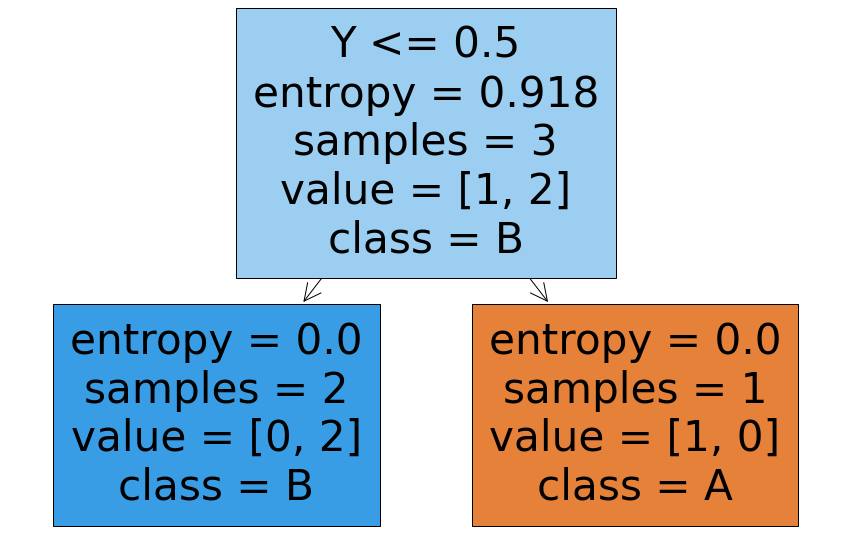

In [12]:
# Decision tree diagram
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(decision_tree, 
                   feature_names=df.columns[:-1],  
                   class_names=sorted(df['Category'].unique()),
                   filled=True)

In [13]:
# feature importance
for x,y in zip(decision_tree.feature_names_in_,decision_tree.feature_importances_):
    print(f"{x}: {y}")

X: 0.0
Y: 1.0
Z: 0.0


### **Here, we see Y has the most feature importance and it sits at the root node according to the tree plot diagram.**

# Random Forest Classifier

In [14]:
# Random Forest Classifier model fit
rfc = RandomForestClassifier(criterion='entropy', random_state=1)
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', random_state=1)

In [15]:
# predictions of the model
rfc_predictions = rfc.predict(X_test)
# Confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test,rfc_predictions))
print('-------------------------------------------------------')
# print classification report
print('Classification Report:')
print(classification_report(y_test, rfc_predictions))
print('-------------------------------------------------------')
# model accuracy score
print(f'Model accuracy: {accuracy_score(y_test, rfc_predictions)}')

Confusion Matrix:
[[1]]
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

-------------------------------------------------------
Model accuracy: 1.0


In [16]:
# feature importance
for x,y in zip(rfc.feature_names_in_,rfc.feature_importances_):
    print(f"{x}: {y}")

X: 0.1849413373390301
Y: 0.8150586626609698
Z: 0.0


### **Even in Random forest Classifier, we see Y has the most feature importance.**